In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# from pprint import pprint

# from sklearn.datasets import fetch_20newsgroups

import re
import nltk
from nltk.corpus import stopwords

import time
from sentence_transformers import SentenceTransformer

from PIL import Image 
import os 
import pytesseract 

In [4]:
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

path = "D:\\CS\\Research\\CCPS_Research"

In [5]:
def extract_text(path):
    data = {}
    for images in os.listdir(path):
        if images.endswith(".jpg") or images.endswith(".jpeg"):
            # print("file name: ",images)
            text = pytesseract.image_to_string(Image.open(f"{path}\\{images}"))
            # print("data: ",text)
            data[images] = text 
            
    # print("End of all file in the directory")
    # print(data)
    return data

In [6]:
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text

In [7]:
data = extract_text(path)
df = pd.DataFrame(data.items(), columns=['filename','text'])
print(df)

      filename                                               text
0  images.jpeg  This is a handwritten\nexample\n\nWrite as goa...


In [8]:
df['text_cleaned'] = df['text'].apply(lambda text: preprocess_text(text))
df = df[df['text_cleaned'] != '']

In [10]:
st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_transformers = np.vstack(df['encode_transforemers'])

Elapsed time: 3.24 seconds


In [11]:
print(X_transformers)

[[-0.03200226  0.34872943 -0.7731296  -0.8151326   0.2563459   0.18224916
   0.46976882  0.33154377  0.46573043  0.12344986 -0.3701045   0.3387176
   0.4297915  -0.17363878  0.52406627 -0.320213   -0.3086584   0.29622287
  -0.8488646  -0.05158096  0.97137386  0.18135345  0.15663634 -0.05735898
   0.34785178  0.33256793 -0.0178377   0.25129274 -0.10909184 -0.5804238
  -0.46769407 -0.27111492  0.18635584  0.4031703   0.4830532   0.5624607
  -0.34386823  0.3734552  -0.25385052 -0.09832232 -0.18420674 -0.04307785
   0.15048906  0.12073522  0.31610376  0.33685526 -0.47388074  0.05414938
  -0.43108848  0.3483603  -0.07534958 -0.02350092 -0.6891286  -0.4304862
   0.24253635  0.10266727  0.03749701  0.01658035  0.19769344 -0.29968897
  -0.37188166 -0.51120317 -0.2967152   0.08064085  0.3299196  -0.25736123
  -0.46296117  0.18285704 -0.70453864  0.03593107  0.5655672  -0.1156048
   0.09380756  0.14868937  0.6845517  -0.11570142 -0.87703556  0.10394692
  -0.37157646 -0.11021226 -0.02048729  0.25

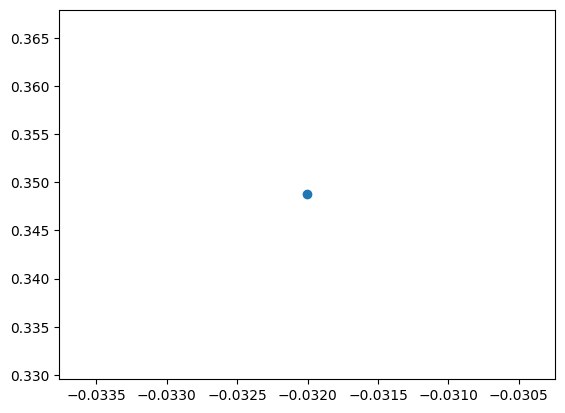

In [12]:
plt.scatter(X_transformers[:,0], X_transformers[:,1])
plt.show()

In [13]:
cl = {-1: 'k',
 0 : 'r',
 1 : 'g',
 2 : 'b',
 3 : 'c',
 4 : 'm',
 5 : 'y'}

In [14]:
from sklearn.cluster import DBSCAN 

db_default = DBSCAN().fit(X_transformers) 
db_labels = db_default.labels_

print("DBSCAN")
print(np.unique(db_default.labels_))
print(db_default.labels_)

DBSCAN
[-1]
[-1]


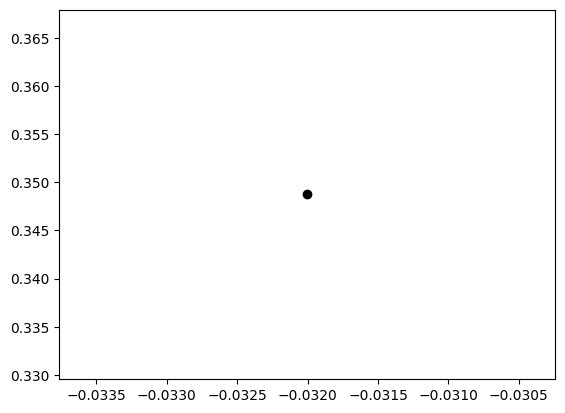

In [15]:
cvec = [cl[label] for label in db_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
plt.show()

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=1, random_state=0, n_init="auto").fit(X_transformers)
kmeans_labels = kmeans.labels_

print("Kmeans")
print(kmeans.labels_)
print(np.unique(kmeans.labels_))

Kmeans
[0]
[0]


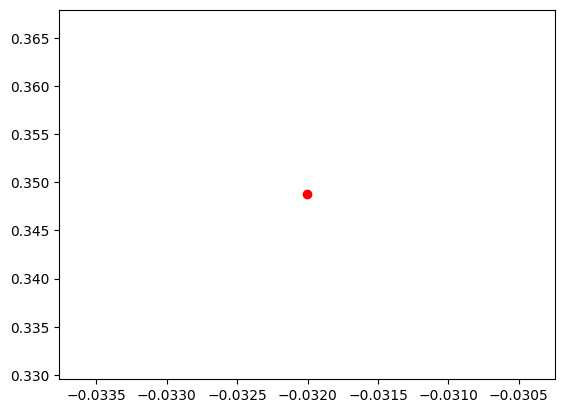

In [18]:
cvec = [cl[label] for label in kmeans_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
plt.show()